In [11]:

import cv2
from datetime import datetime
from pathlib import Path
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [12]:
DATETIME_STR = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

PRINT_PROGRESS_EVERY_N_PERCENT = 1

ADD_TIME_TO_FILENAME = True

############### PF #############
WIDTH = 1280
HEIGHT = 720
FPS = 60

# Format from DarkLabel software: (frame_index, classname, instance_id, is_difficult, x, y, w, h) 
#                                      0            1          2            3         4  5  6  7

# Format for events: (x, y, t (us or ms), p)
EVENTS_CSV_X_COL = 0
EVENTS_CSV_Y_COL = 1
EVENTS_CSV_T_COL = 2
EVENTS_CSV_P_COL = 3

# Paths
TRAJECTORIES_CSV_DIR = Path("output/extracted_trajectories")
OUTPUT_BASE_DIR = Path("output/inspect_trajectory_hist")

EVENTS_CSV_HAS_HEADER = False
LABELS_CSV_HAS_HEADER = False

##################################

# Precision of the timestamp: for mikroseconds: 1000000, for milliseconds: 1000
TIMESTEPS_PER_SECOND = 1_000_000
# If timestamp in mikroseconds: -> mikroseconds per frame
TIMESTEPS_PER_FRAME = (1 / FPS) * TIMESTEPS_PER_SECOND
HALF_FRAME_TIME = TIMESTEPS_PER_FRAME // 2
T_SCALE = 0.002 # 0.002 is good
INV_T_SCALE = 1 / T_SCALE

T_BUCKET_LENGTH = 1000 * 100 # in us; 50 or 100ms is good?
BINS_PER_T_BUCKET = 250 # for the tx, ty projection: Sub-bins per bucket on the t axis

STAT_BINS_PER_T_BUCKET = 50
STAT_BIN_WIDTH = T_BUCKET_LENGTH / STAT_BINS_PER_T_BUCKET # in us

SAVE_IMAGE_DPI = 300

np.set_printoptions(suppress=True,precision=3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [13]:
# Find all files from directory
# trajectory_files = TRAJECTORIES_CSV_DIR.glob("*_trajectories*/*.csv")

# trajectory_filepath = TRAJECTORIES_CSV_DIR / "hauptsächlichBienen1_trajectories_2024-06-02_13-08-11/hauptsächlichBienen1_id9_pts38695_start7674867.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / "vieleSchmetterlinge2_trajectories_2024-05-30_11-31-51/42.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / "1_l-l-l_trajectories_2024-05-29_15-27-12/2.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / "3_classified/_with_bboxes/hauptsächlichBienen1_trajectories_bbox/9_bee_pts20400_start5289327.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / "3_classified/hauptsächlichBienen1_trajectories/9_bee_pts18648_start5289327.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / "3_classified/3_m-h-h_trajectories/13_bee_pts25416_start32130583.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / "3_classified/3_m-h-h_trajectories/6_bee_pts40999_start15878090.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / "3_classified/3_m-h-h_trajectories/0_bee_pts217225_start2417504.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / "3_classified/mb-dra1-1_trajectories/0_dra_pts59532_start1850138.csv"
trajectory_filepath = TRAJECTORIES_CSV_DIR / "3_classified/mb-dra1-1_trajectories/10_dra_pts186904_start30916677.csv"


In [14]:
df_orig = pd.read_csv(trajectory_filepath, sep=',', header="infer")

df = df_orig.copy()
display(df.head())
df = df[["x","y","t"]]
display(df.head())
# print(df["bb_corner_index"].unique())

,x,y,t,r,g,b,is_confident,bb_frame_index,bb_corner_index
0,17,86,0.000,255,255,255,1,3710,-1
1,27,93,0.004,255,255,255,1,3710,-1
2,15,103,0.026,255,255,255,1,3710,-1
3,31,106,0.038,255,255,255,1,3710,-1
4,14,87,0.052,255,255,255,1,3710,-1


,x,y,t
0,17,86,0.000
1,27,93,0.004
2,15,103,0.026
3,31,106,0.038
4,14,87,0.052


In [15]:
min_t = df["t"].min()
if min_t < 0:
    print("Warning: Min t value is < 0! ", min_t, ". Dropping rows with t<0!")
    inds = df[df.t < 0].index
    df.drop(inds, inplace=True)

# calc back to t_real (in us)
df["t_real"] = (df.loc[:,"t"] * INV_T_SCALE).round().astype('Int64')

max_t_real = df.t_real.iloc[-1]
print("max_t_real", max_t_real)

max_t_str = f"{int((max_t_real / TIMESTEPS_PER_SECOND) // 60):0>2}m:{(max_t_real / TIMESTEPS_PER_SECOND % 60):0>2.2f}s"
print("max_t_str", max_t_str)


# Biene hat 200 flügelschläge pro sek. Das sind 5ms pro flügelschlag.
# Es sollen 10 Flügelschläge in ein Fenster passen. Also 5*10=50ms oder 50000us
# number_of_buckets = int(np.ceil(max_t/T_BUCKET_WIDTH))


df["fragment_index"] = df.t_real.floordiv(T_BUCKET_LENGTH).astype('Int64')
# number_of_buckets = len(df["t_bucket"].unique())
number_of_fragments = int(np.ceil(max_t_real/T_BUCKET_LENGTH))

print("number of fragments", number_of_fragments, "with", T_BUCKET_LENGTH//1000, "ms each")

df["stat_bucket"]  = df.t_real.floordiv(STAT_BIN_WIDTH).astype('Int64')
print("number of stat buckets per fragment", STAT_BINS_PER_T_BUCKET)
print("number of stat buckets total", len(df["stat_bucket"].unique()))

# t_col_buckets = t_col_buckets[t_col_buckets!=-1]
ev_count_per_fragment = df["fragment_index"].value_counts(sort=False).sort_index()
ev_count_per_fragment = ev_count_per_fragment.reindex(list(range(0, number_of_fragments)), fill_value=0)
print("event count per bucket:")
print(ev_count_per_fragment)
print(len(ev_count_per_fragment.index))

display(df)

max_t_real 824978
max_t_str 00m:0.82s
number of fragments 9 with 100 ms each
number of stat buckets per fragment 50
number of stat buckets total 413
event count per bucket:
0    27672
1    25527
2    23077
3    29290
4    22549
5    23194
6    15170
7    16724
8     3701
Name: fragment_index, dtype: Int64
9


,x,y,t,t_real,fragment_index,stat_bucket
0,17,86,0.000,0,0,0
1,27,93,0.004,2,0,0
2,15,103,0.026,13,0,0
3,31,106,0.038,19,0,0
4,14,87,0.052,26,0,0
...,...,...,...,...,...,...
186899,1265,304,1649.830,824915,8,412
186900,1243,290,1649.854,824927,8,412
186901,1248,293,1649.860,824930,8,412
186902,1277,304,1649.910,824955,8,412


## Hist for Number of events per time frame of a Trajectory

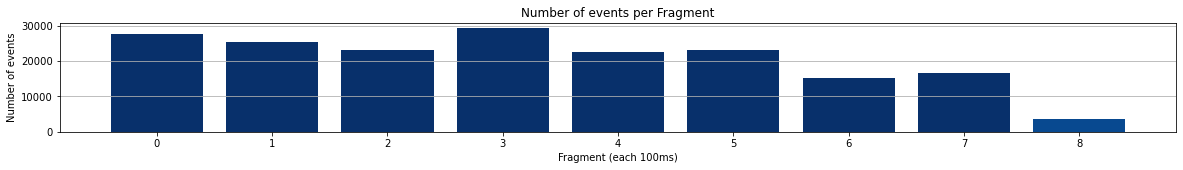

In [16]:
# Blues: light=low, saturated=high
cmap = plt.cm.get_cmap('Blues')

def event_count_to_color(n):
    MAXLOG = 12 # 13 = ld(8192)
    MAX = 2**MAXLOG
    n = min(MAX, n)
    # n = np.log2(n)
    # n = np.clip(n, 0, MAXLOG)
    return cmap(n/MAX)


ec_colors = ev_count_per_fragment.apply(event_count_to_color)
ec_colors = ec_colors.to_numpy()
ec_colors = np.array([ *ec_colors ])

xx = list(range(number_of_fragments))
yy = ev_count_per_fragment

fig = plt.figure(figsize = (20, 2))
 
# creating the bar plot
plt.bar(xx, yy, color=ec_colors, width=0.8, align="center", tick_label=xx)
 
plt.xlabel(f"Fragment (each {T_BUCKET_LENGTH//1000}ms)")
plt.ylabel("Number of events")
plt.title("Number of events per Fragment")
# plt.yticks([2**10, 2**11, 2**12, 2**13])
plt.grid(axis="y")
plt.show()


## Std per fragment

In [17]:
# Calculate variance of parts of a fragment, then take avg per fragment

agg = {
    "x":"std",
    "y":"std",
    "t":"size"
}

df1 = df.groupby([df.fragment_index, df.stat_bucket]).agg(agg)
df1.rename(columns={"t":"event_count"}, inplace=True)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
display("STD (x,y) per stat_bucket", df1)

# df1["std"] = df1[["x","y"]].sum(axis=1, min_count=1)
df1["std"] = df1[["x","y"]].mean(axis=1)
# df1["std"] = df1[["x","y"]].max(axis=1)
df1["std"].fillna(0.0, inplace=True)
display("STD (x+y) per stat_bucket", df1)

agg1 = {
    "std":"mean",
    "event_count":"sum",
}

# take min of n smallest stds
# agg_std = df1["std"].groupby(level=0).nsmallest(1).groupby(level=0).mean()
# agg_std = agg_std.reindex(list(range(0, number_of_fragments)), fill_value=0.0)

df1 = df1.groupby(level=0).agg(agg1)
# df1.columns = df1.columns.get_level_values(1)
# df1["std"] = agg_std
# df1.rename(columns={"mean":"std_mean","min":"std_min","sum":"event_count"}, inplace=True)
df1 = df1.reindex(list(range(0, number_of_fragments)))
display("mean STD per fragment over its subfragments", df1)


'STD (x,y) per stat_bucket'

x      y  event_count
fragment_index stat_bucket                           
0              0            9.145 11.275          432
               1            9.818 11.527          449
               2           10.643 11.861          505
               3           12.119 12.066          586
               4           11.887 12.836          598
...                           ...    ...          ...
8              408         13.654  6.106          320
               409         13.784  6.017          335
               410         12.746  5.231          266
               411         10.969  5.036          210
               412          9.026  5.289          110

[413 rows x 3 columns]

'STD (x+y) per stat_bucket'

x      y  event_count    std
fragment_index stat_bucket                                  
0              0            9.145 11.275          432 10.210
               1            9.818 11.527          449 10.672
               2           10.643 11.861          505 11.252
               3           12.119 12.066          586 12.092
               4           11.887 12.836          598 12.361
...                           ...    ...          ...    ...
8              408         13.654  6.106          320  9.880
               409         13.784  6.017          335  9.901
               410         12.746  5.231          266  8.988
               411         10.969  5.036          210  8.002
               412          9.026  5.289          110  7.158

[413 rows x 4 columns]

'mean STD per fragment over its subfragments'

,std,event_count
fragment_index,,
0,12.681,27672
1,10.895,25527
2,10.980,23077
3,9.381,29290
4,10.152,22549
5,9.103,23194
6,10.000,15170
7,10.188,16724
8,9.157,3701


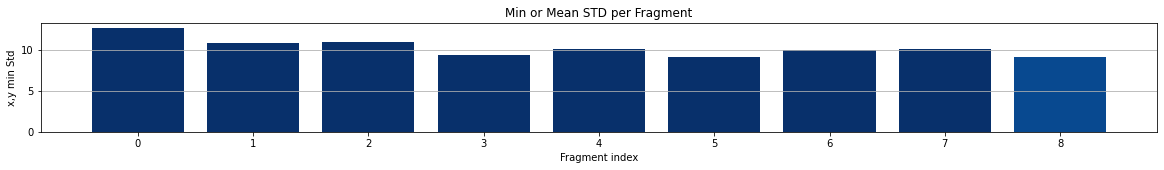

In [18]:
# mean
# xx = df1.index
# yy = df1["std_mean"]

# fig = plt.figure(figsize = (20, 2))
# # creating the bar plot
# plt.bar(x=xx, height=yy, color=colors, width=0.8, align="center", tick_label=xx)
# plt.title("Mean STD per Fragment")
# plt.xlabel("Fragment index")
# plt.ylabel("x,y STD")
# plt.grid(axis="y")
# plt.show()

# min
xx = df1.index
yy = df1["std"]

fig = plt.figure(figsize = (20, 2))
# creating the bar plot
plt.bar(x=xx, height=yy, color=ec_colors, width=0.8, align="center", tick_label=xx)
plt.title("Min or Mean STD per Fragment")
plt.xlabel("Fragment index")
plt.ylabel("x,y min Std")
plt.grid(axis="y")
plt.show()

## Project Trajectory to 2D plane: Only use (t,x) or (t,y)

In [19]:
def get_projected_heatmap(df, col1, col2, bins_x, bins_y):
    df_proj = df.loc[:,[col1, col2]]

    t_max = df_proj[col1].iloc[-1]
    # [[xmin, xmax], [ymin, ymax]]
    ty_hist_range = [ [0, int(t_max)], [0, bins_y] ]

    heatmap, xedges, yedges = np.histogram2d(df_proj[col1], df_proj[col2], bins=[bins_x, bins_y], density=False, range=ty_hist_range)
    heatmap = heatmap.T
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    # heatmap = np.log2(heatmap+1)
    return df_proj, heatmap, extent

def arg_bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    ymin, ymax = np.nonzero(rows)[0][[0, -1]]
    xmin, xmax = np.nonzero(cols)[0][[0, -1]]
    return ymin, ymax+1, xmin, xmax+1

def y_crop_to_used_area(image, padding=0):
    image_height = image.shape[0]
    ymin, ymax, xmin, xmax = arg_bbox(image)
    ymin = max(0, ymin-padding)
    ymax = min(image_height-1, ymax+padding)
    return image[ymin:ymax,:]

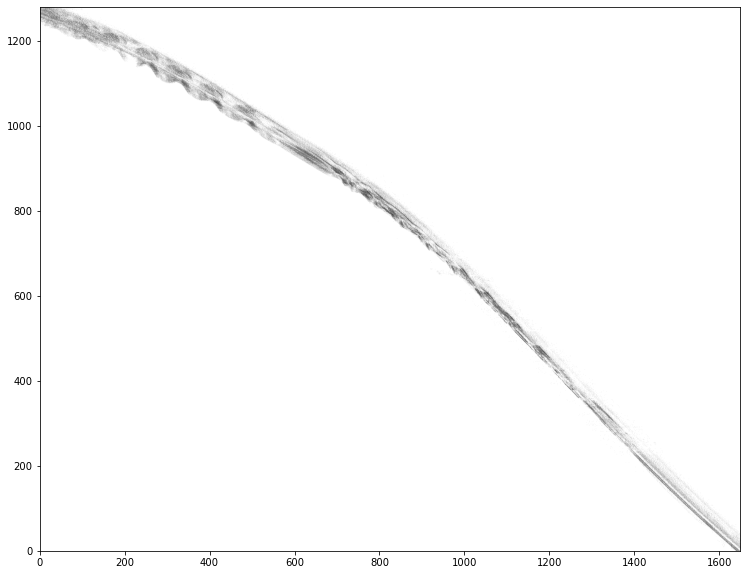

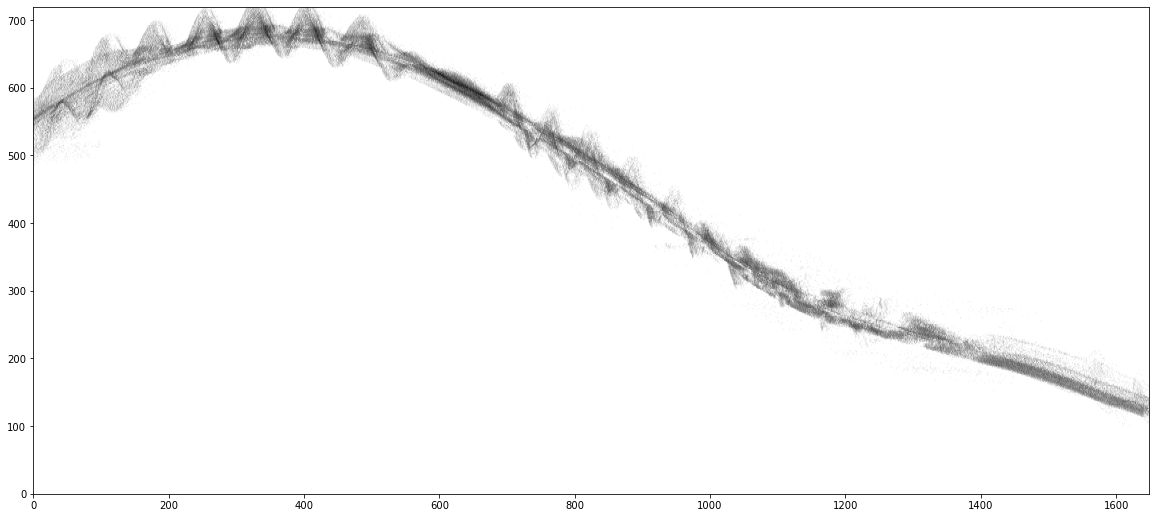

In [20]:
tx_df, tx_heatmap, tx_extent = get_projected_heatmap(df, "t", "x", number_of_fragments*BINS_PER_T_BUCKET, WIDTH)
tx_heatmap = y_crop_to_used_area(tx_heatmap, 50)

log_tx_heatmap = np.log2(tx_heatmap+1)
plt.figure(figsize = (20, 10))
# plt.xlim(left=0, right=number_of_buckets)
plt.imshow(log_tx_heatmap, extent=tx_extent, origin='upper', cmap="Greys")
plt.show()

ty_df, ty_heatmap, ty_extent = get_projected_heatmap(df, "t", "y", number_of_fragments*BINS_PER_T_BUCKET, HEIGHT)
ty_heatmap = y_crop_to_used_area(ty_heatmap, 50)

log_ty_heatmap = np.log2(ty_heatmap+1)
plt.figure(figsize = (20, 10))
# plt.xlim(left=0, right=number_of_buckets)
plt.imshow(log_ty_heatmap, extent=ty_extent, origin='upper', cmap="Greys")
plt.show()

Wie ty und tx kombinieren?
x und y range auf 0 bis 1 normalisieren, dann x*y rechnen?

## Combined chart

In [21]:
# colors for bars in events histogram
bar_colors = []
good_number = 4096
for x in ev_count_per_fragment:
    if x >= good_number*2:
        bar_colors.append("navy")
    elif x >= good_number:
        bar_colors.append("royalblue")
    elif x >= good_number//2:
        bar_colors.append("orange")
    else:
        bar_colors.append("tomato")

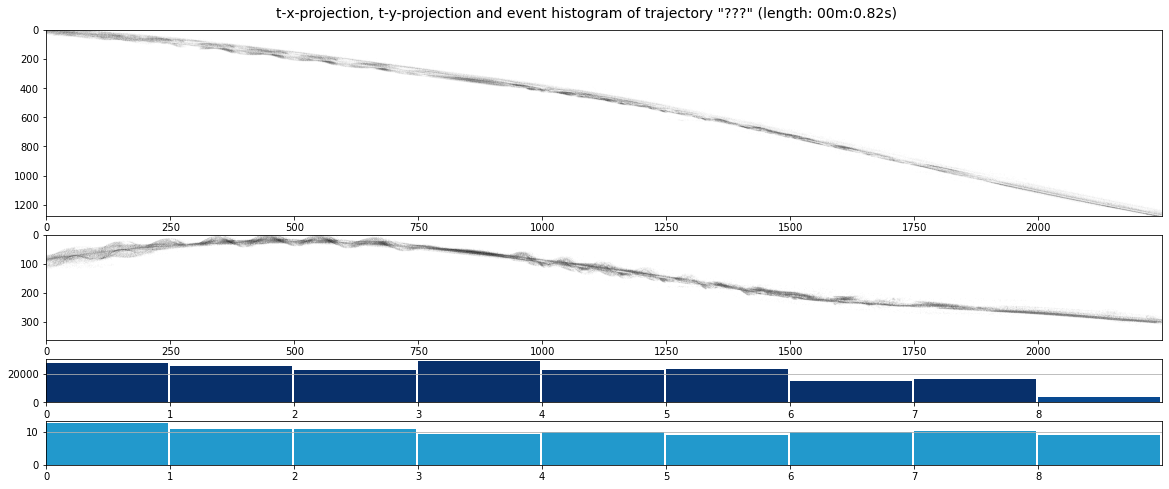

In [22]:
# Show all x ticks if less than 40 fragments; Else its too much text
xtick_label = ev_count_per_fragment.index if number_of_fragments <= 40 else None


fig, axs = plt.subplots(4, gridspec_kw={'height_ratios': [1280,720,300,300]})
fig.set_size_inches(20, 8)
# fig.set_figwidth(20)
fig.suptitle(f't-x-projection, t-y-projection and event histogram of trajectory "???" (length: {max_t_str})', size=14, y=0.92)

axs[0].imshow(log_tx_heatmap, origin='upper', cmap="Greys", aspect="auto")

axs[1].imshow(log_ty_heatmap, origin='upper', cmap="Greys", aspect="auto")

axs[2].set_xlim(left=0, right=number_of_fragments)
axs[2].bar(x=list(range(number_of_fragments)), height=ev_count_per_fragment, color=ec_colors, width=0.98, align="edge", tick_label=xtick_label)
axs[2].grid(axis="y")
# axs[2].set_xlim(left=0, right=number_of_buckets)

axs[3].set_xlim(left=0, right=number_of_fragments)
# axs[2].bar(list(range(number_of_buckets)), event_counts_per_bucket, width=1.0, align="edge", color=bar_colors)
axs[3].bar(x=df1.index, height=df1["std"], color="#2299cc", width=0.98, align="edge", tick_label=xtick_label)
axs[3].grid(axis="y")



-> Histogramm ist wie erste Ableitung von t-y-Projektion! 



## Export part of projected trajectory as pretty image
### First find bbox around used part of the image

In [23]:
# Return bbox indices of bbox around all non zero values
def arg_bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    ymin, ymax = np.nonzero(rows)[0][[0, -1]]
    xmin, xmax = np.nonzero(cols)[0][[0, -1]]
    return ymin, ymax+1, xmin, xmax+1

def hist2d_to_image(arr):
    max_val_ln = np.log(arr.max()+1)
    # log1p is ln(x+1)
    arr = np.log1p(arr) / max_val_ln # -> [0, 1]
    # make 0=white (=255), 1=black (=0)
    arr = ((arr * -1) + 1.0) * 255.0
    return arr

67 180 0 250
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
shape (113, 250) float64
0.0 222.2796731760505 255.0
[[255.    189.731 255.    ... 255.    255.    255.   ]
 [255.    255.    255.    ... 255.    255.    255.   ]
 [255.    255.    255.    ... 255.    255.    255.   ]
 ...
 [255.    255.    255.    ... 255.    255.    255.   ]
 [255.    255.    255.    ... 255.    255.    255.   ]
 [255.    255.    255.    ... 255.    255.    255.   ]]


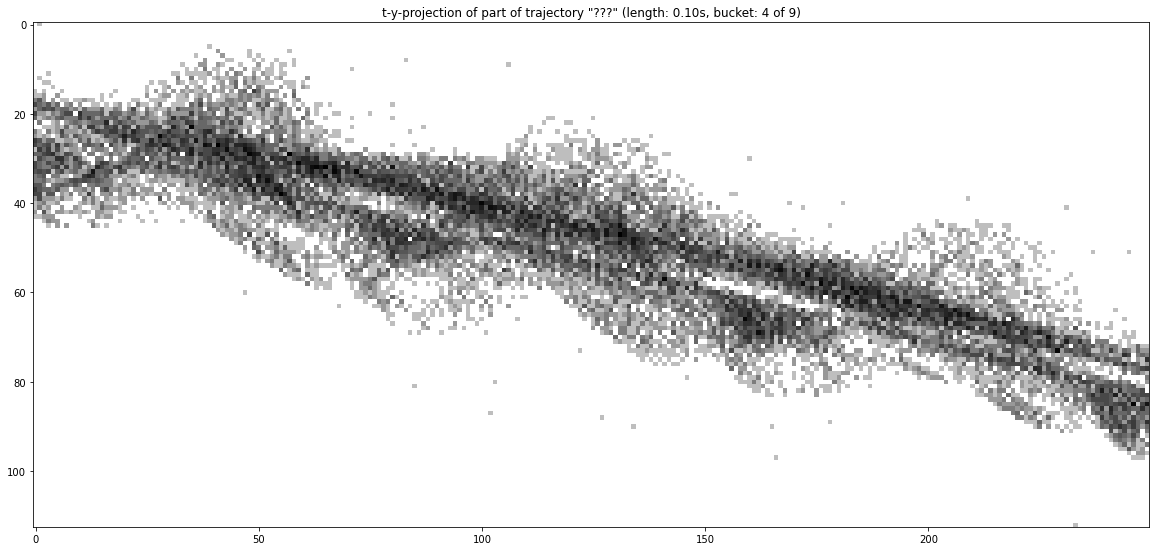

In [24]:
bucket_index = 4
t_start = BINS_PER_T_BUCKET*bucket_index
t_length = BINS_PER_T_BUCKET
t_length_real = (t_length / BINS_PER_T_BUCKET) * T_BUCKET_LENGTH
t_length_str = f"{(t_length_real / TIMESTEPS_PER_SECOND):0>2.2f}s"
t_end = t_start+t_length

ty_heatmap_tcrop = ty_heatmap[:,t_start:t_end]

# print(ty_heatmap.shape)
# print(ty_heatmap)
# print(np.argmax(ty_heatmap, axis=0)) # findet pro spalte den 
# print(np.argmax(ty_heatmap, axis=0).shape)
# print(np.argmax(ty_heatmap, axis=1).shape)

# Crop to used area
ymin, ymax, xmin, xmax = arg_bbox(ty_heatmap_tcrop)
print(ymin, ymax, xmin, xmax)
ty_heatmap_tycrop = ty_heatmap_tcrop[ymin:ymax,:]

nonzero_mask = (ty_heatmap_tycrop != 0).astype(float)
zero_mask = (ty_heatmap_tycrop == 0).astype(float)
print(nonzero_mask)

# ty_heatmap_tycrop = np.log1p(ty_heatmap_tycrop)
# ty_heatmap_tycrop = np.log10(np.minimum(ty_heatmap_tycrop + zero_mask, 10)) * nonzero_mask

ty_heatmap_tycrop = hist2d_to_image(ty_heatmap_tycrop)

print("shape", ty_heatmap_tycrop.shape, ty_heatmap_tycrop.dtype)
print(ty_heatmap_tycrop.min(), ty_heatmap_tycrop.mean(), ty_heatmap_tycrop.max())
print(ty_heatmap_tycrop)

# Show image
plt.figure(figsize = (20, 10))
plt.title(f't-y-projection of part of trajectory "???" (length: {t_length_str}, bucket: {bucket_index} of {number_of_fragments})')
# plt.xlim(left=0, right=number_of_buckets)
plt.imshow(ty_heatmap_tycrop, origin='upper', cmap="gray")
plt.show()

# Save image with OpenCV
filename = "orig_res_" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + ".png"
filepath = "output/figures/trajectory_images/" + filename
cv2.imwrite(filepath, ty_heatmap_tycrop) # muss rgb sein?

# Save with PLT
filename = "plt_" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + ".png"
filepath = "output/figures/trajectory_images/" + filename
filepath = Path(filepath)
filepath.parent.mkdir(parents=True, exist_ok=True)
fig = plt.figure(frameon=False)
ax = fig.add_subplot()
ax.imshow(ty_heatmap_tycrop, aspect='equal', interpolation="none", cmap="gray")
ax.axis('off')
ax.margins(0)
plt.savefig(filepath, format="png", bbox_inches="tight", pad_inches=0, dpi=SAVE_IMAGE_DPI)
plt.close()


## 3d visualizations

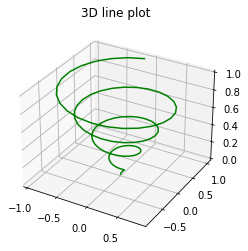

In [25]:
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
z = np.linspace(0, 1, 100)
x = z * np.sin(25 * z)
y = z * np.cos(25 * z)
 
# plotting
ax.plot3D(x, y, z, 'green')
ax.set_title('3D line plot')
plt.show()


In [26]:
trajectory_filepath = TRAJECTORIES_CSV_DIR / \
    "3_classified/_with_bboxes/hauptsächlichBienen1_trajectories_bbox/fragments_time_100ms_4096pts_2024-06-10_23-45-35/9_bee_pts20400_start5289327/frag_9.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / \
#     "3_classified_pf1/_with_bboxes/hauptsächlichBienen1_trajectories_bbox/fragments_time_4000ms_4096pts_2024-06-12_15-10-31/18_bee_pts34743_start10928909/frag_1.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / \
#     "2_separated_2024-06-09_14-46-59/_with_bboxes/1_l-l-l_trajectories_bbox/fragments_time_100ms_4096pts_2024-06-10_23-17-48/0_ins_pts1073898_start1476947/frag_90.csv"

df3 = pd.read_csv(trajectory_filepath, sep=',', header="infer")
print(df3.head())

events_df = df3.loc[df3["bb_corner_index"].astype(int) == -1]
bb_events_df = df3[df3["bb_corner_index"].astype(int) >= 0]

print(len(events_df), len(events_df.index), len(bb_events_df))

     x    y      t    r    g    b  is_confident  bb_frame_index  \
0  649  441 -0.038  127  255  212             0             742   
1  676  441 -0.038  127  255  212             0             742   
2  649  473 -0.038  127  255  212             0             742   
3  676  473 -0.038  127  255  212             0             742   
4  669  461  0.228  255  255  255             1             742   

   bb_corner_index  
0                0  
1                1  
2                2  
3                3  
4               -1  
4096 4096 88


In [27]:
bboxes = {} # frame, bbox points
for i,row in bb_events_df.iterrows():
    x = int(row["x"])
    y = int(row["y"])
    t = float(row["t"])
    fi = int(row["bb_frame_index"])
    corner = int(row["bb_corner_index"])
    if fi not in bboxes:
        bboxes[fi] = {}
    if corner >= 0:
        bboxes[fi][corner] = (x,y,t)

# for k,v in bboxes.items():
#     print(len(v), k,v)

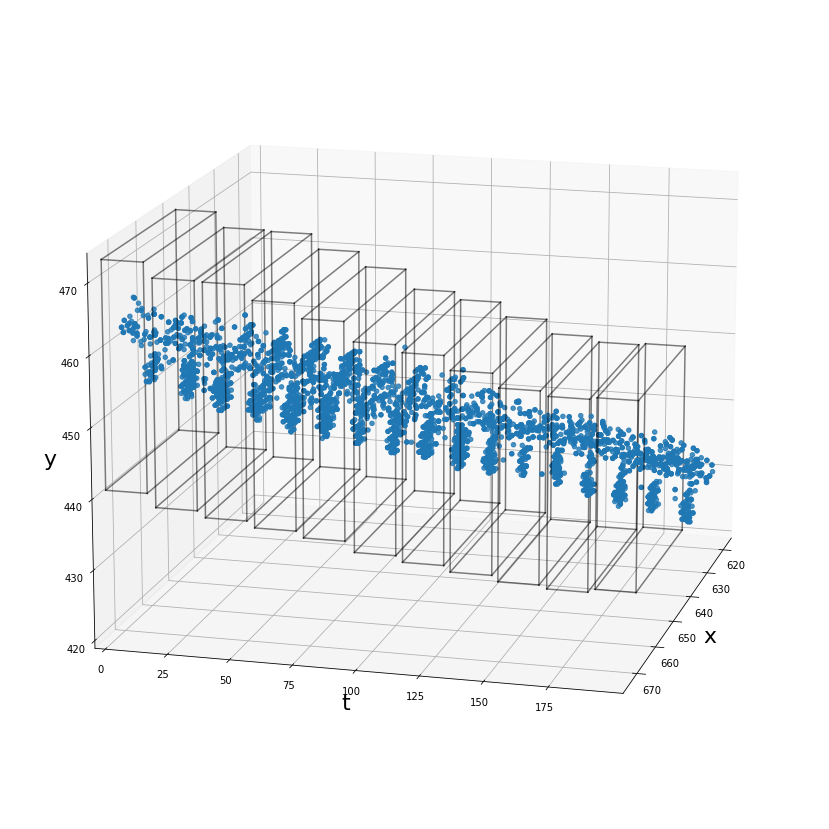

In [28]:


fig = plt.figure(figsize=(15,15))
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d',computed_zorder=False)

# syntax for 3-D projection
x = events_df["x"]
y = events_df["y"]
t = events_df["t"]
c = events_df["bb_frame_index"].astype(int)
ax.scatter(x, t, y, alpha=0.8, cmap='cool', zorder=1)

# xx = np.array([0,1,0,1,0,1,0,1]) * 20 + 640
# tt = np.array([0,0,0,0,1,1,1,1]) * 20 + 100
# yy = np.array([0,0,1,1,0,0,1,1]) * 20 + 440

lines_start = [0,0,2,1,4,4,6,5,0,1,2,3]
lines_end =   [1,2,3,3,5,6,7,7,4,5,6,7]
lines_zorder= [2,2,2,2,0,0,0,0,0,0,1,1]
for k,bb in bboxes.items():
    if len(bb) != 8:
        continue
    for i in range(len(lines_start)):
        a = lines_start[i]
        b = lines_end[i]
        zo = lines_zorder[i]
        pointa = bb[a]
        pointb = bb[b]
        ax.plot([pointa[0],pointb[0]], [pointa[2],pointb[2]], [pointa[1],pointb[1]], color='black', alpha=0.5, zorder=zo)

# syntax for plotting
ax.set_xlabel('x', fontsize=22)
ax.set_ylabel('t', fontsize=22)
ax.set_zlabel('y', fontsize=22)
ax.elev = 15
ax.azim = 15
# ax.axis('off')
ax.margins(0)
plt.show()

In [29]:
# Fragmented by time
# frag_1.csv - frag7.csv
dir = "output/extracted_trajectories/_from_h5/1_l-l-l_trajectories/fragmented4096_windows1/3"




